# Image Compression

In [1]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageEnhance
from IPython.display import display
from torchvision.transforms import ToPILImage, PILToTensor
from walloc import walloc
from walloc.walloc import latent_to_pil, pil_to_latent
class Config: pass

### Load the model from a pre-trained checkpoint

```wget https://hf.co/danjacobellis/walloc/resolve/main/RGB_Li_12c_J3_nf8_v1.0.2.pth```

In [2]:
device = "cpu"
checkpoint = torch.load("RGB_Li_12c_J3_nf8_v1.0.2.pth",map_location="cpu",weights_only=False)
codec_config = checkpoint['config']
codec = walloc.Codec2D(
    channels = codec_config.channels,
    J = codec_config.J,
    Ne = codec_config.Ne,
    Nd = codec_config.Nd,
    latent_dim = codec_config.latent_dim,
    latent_bits = codec_config.latent_bits,
    lightweight_encode = codec_config.lightweight_encode
)
codec.load_state_dict(checkpoint['model_state_dict'])
codec = codec.to(device)
codec.eval();

### Load an example image

```wget "https://r0k.us/graphics/kodak/kodak/kodim05.png"```

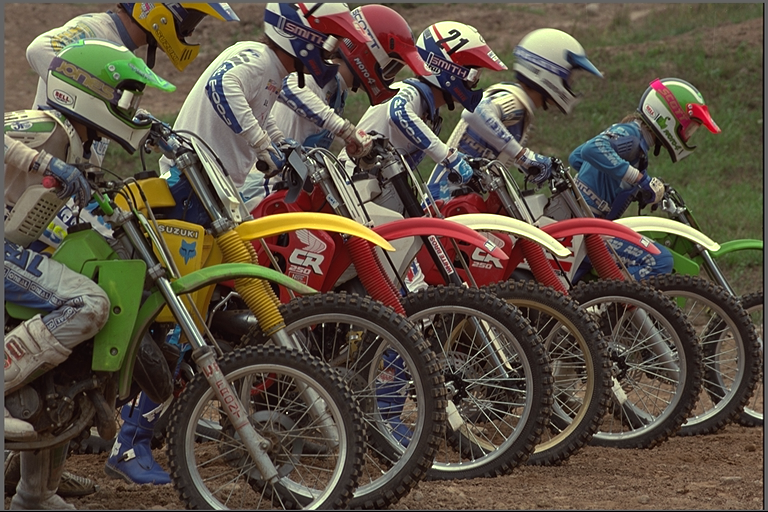

In [3]:
img = Image.open("kodim05.png")
img

### Full encoding and decoding pipeline with .forward()

* If `codec.eval()` is called, the latent is rounded to nearest integer.

* If `codec.train()` is called, uniform noise is added instead of rounding.

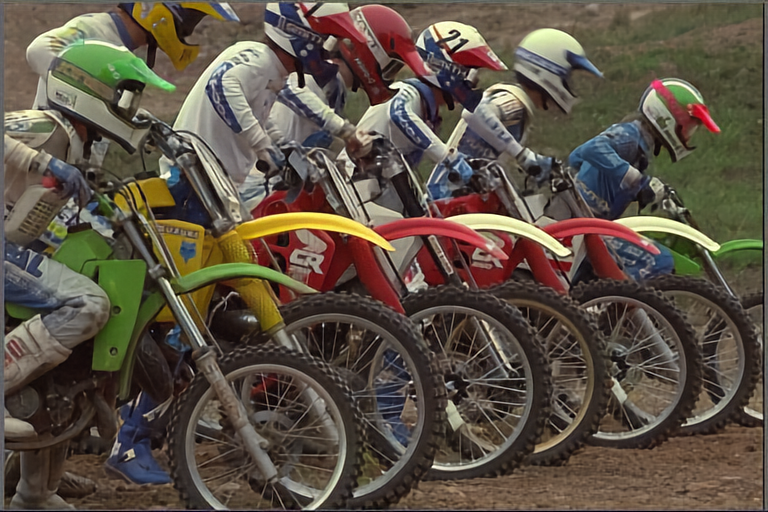

In [4]:
with torch.no_grad():
    codec.eval()
    x = PILToTensor()(img).to(torch.float)
    x = (x/255 - 0.5).unsqueeze(0).to(device)
    x_hat, _, _ = codec(x)
ToPILImage()(x_hat[0]+0.5)

### Accessing latents

In [5]:
with torch.no_grad():
    X = codec.wavelet_analysis(x,J=codec.J)
    z = codec.encoder[0:2](X)
    z_hat = codec.encoder[2](z)
    X_hat = codec.decoder(z_hat)
    x_rec = codec.wavelet_synthesis(X_hat,J=codec.J)
print(f"dimensionality reduction: {x.numel()/z.numel()}×")

dimensionality reduction: 16.0×


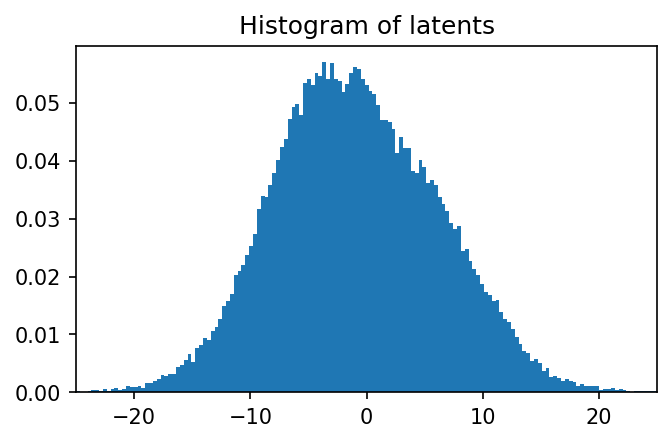

In [6]:
plt.figure(figsize=(5,3),dpi=150)
plt.hist(
    z.flatten().numpy(),
    range=(-25,25),
    bins=151,
    density=True,
);
plt.title("Histogram of latents")
plt.xlim([-25,25]);

# Lossless compression of latents

In [7]:
def scale_for_display(img, n_bits):
    scale_factor = (2**8 - 1) / (2**n_bits - 1)
    lut = [int(i * scale_factor) for i in range(2**n_bits)]
    channels = img.split()
    scaled_channels = [ch.point(lut * 2**(8-n_bits)) for ch in channels]
    return Image.merge(img.mode, scaled_channels)

### Single channel PNG (L)

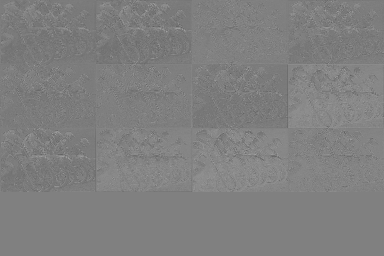

compression_ratio:  26.729991842653856


In [8]:
z_padded = torch.nn.functional.pad(z_hat, (0, 0, 0, 0, 0, 4))
z_pil = latent_to_pil(z_padded,codec.latent_bits,1)
display(scale_for_display(z_pil[0], codec.latent_bits))
z_pil[0].save('latent.png')
png = [Image.open("latent.png")]
z_rec = pil_to_latent(png,16,codec.latent_bits,1)
assert(z_rec.equal(z_padded))
print("compression_ratio: ", x.numel()/os.path.getsize("latent.png"))

### Three channel WebP (RGB)

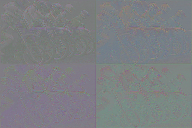

compression_ratio:  28.811254396248536


In [9]:
z_pil = latent_to_pil(z_hat,codec.latent_bits,3)
display(scale_for_display(z_pil[0], codec.latent_bits))
z_pil[0].save('latent.webp',lossless=True)
webp = [Image.open("latent.webp")]
z_rec = pil_to_latent(webp,12,codec.latent_bits,3)
assert(z_rec.equal(z_hat))
print("compression_ratio: ", x.numel()/os.path.getsize("latent.webp"))

### Four channel TIF (CMYK)

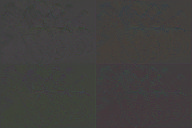

compression_ratio:  21.04034530731638


In [10]:
z_padded = torch.nn.functional.pad(z_hat, (0, 0, 0, 0, 0, 4))
z_pil = latent_to_pil(z_padded,codec.latent_bits,4)
display(scale_for_display(z_pil[0], codec.latent_bits))
z_pil[0].save('latent.tif',compression="tiff_adobe_deflate")
tif = [Image.open("latent.tif")]
z_rec = pil_to_latent(tif,16,codec.latent_bits,4)
assert(z_rec.equal(z_padded))
print("compression_ratio: ", x.numel()/os.path.getsize("latent.tif"))